Моделируемое уравнение: $\dot{\phi}_j = \displaystyle\frac{\mu}{2} \Big[ \omega_j + \displaystyle\frac{d}{R_j}\sum_{k=1}^N{R_k(\sin(\phi_k-\phi_j-\gamma))} \Big], \quad j\neq k$


In [6]:
import numpy as np
from scipy.integrate import odeint
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from numba import jit
from pprint import pprint
import networkx as nx

# np.set_printoptions(threshold=np.inf)

In [7]:
# Параметры системы
N = 128
mu = 0.1
d = 0.3
gamma = np.pi/4

'''
omega = np.ones(N)
R = np.ones((N, N))
np.fill_diagonal(R, 0)  
'''

omega = np.random.rand(N)
R = np.random.rand(N, N)
np.fill_diagonal(R, 0)      # значения на диагонали равны 0
R = 0.5 * (R + R.T)         # делаем матрицу R симметричной

In [8]:
print('omega:')
pprint(omega)
print('------------\n')

print('R:')
pprint(R)
print('------------\n')

omega:
array([0.86523745, 0.05648519, 0.41472555, 0.40568912, 0.77202752,
       0.7906588 , 0.98129859, 0.88311931, 0.62107532, 0.83473735,
       0.01484619, 0.7367514 , 0.84881854, 0.81376275, 0.19314999,
       0.2213634 , 0.83447994, 0.00356684, 0.73322733, 0.05754342,
       0.2163548 , 0.13987125, 0.60854421, 0.79668828, 0.79620244,
       0.49897784, 0.92409025, 0.59612873, 0.29574872, 0.00673237,
       0.74557695, 0.29740661, 0.76955565, 0.29280328, 0.09813568,
       0.29969023, 0.73068396, 0.03610464, 0.49572783, 0.24668623,
       0.93057401, 0.65123557, 0.10441032, 0.20612704, 0.25869004,
       0.04151073, 0.6441316 , 0.56005705, 0.25402981, 0.81226616,
       0.68222388, 0.85690243, 0.43913728, 0.73001542, 0.82144535,
       0.44490859, 0.32893914, 0.44787792, 0.90180655, 0.3213517 ,
       0.72551532, 0.85817418, 0.41764057, 0.63247912, 0.99596823,
       0.56106762, 0.5699922 , 0.07822659, 0.44409101, 0.48135513,
       0.7108302 , 0.26443731, 0.42747554, 0.49883674, 

## Граф

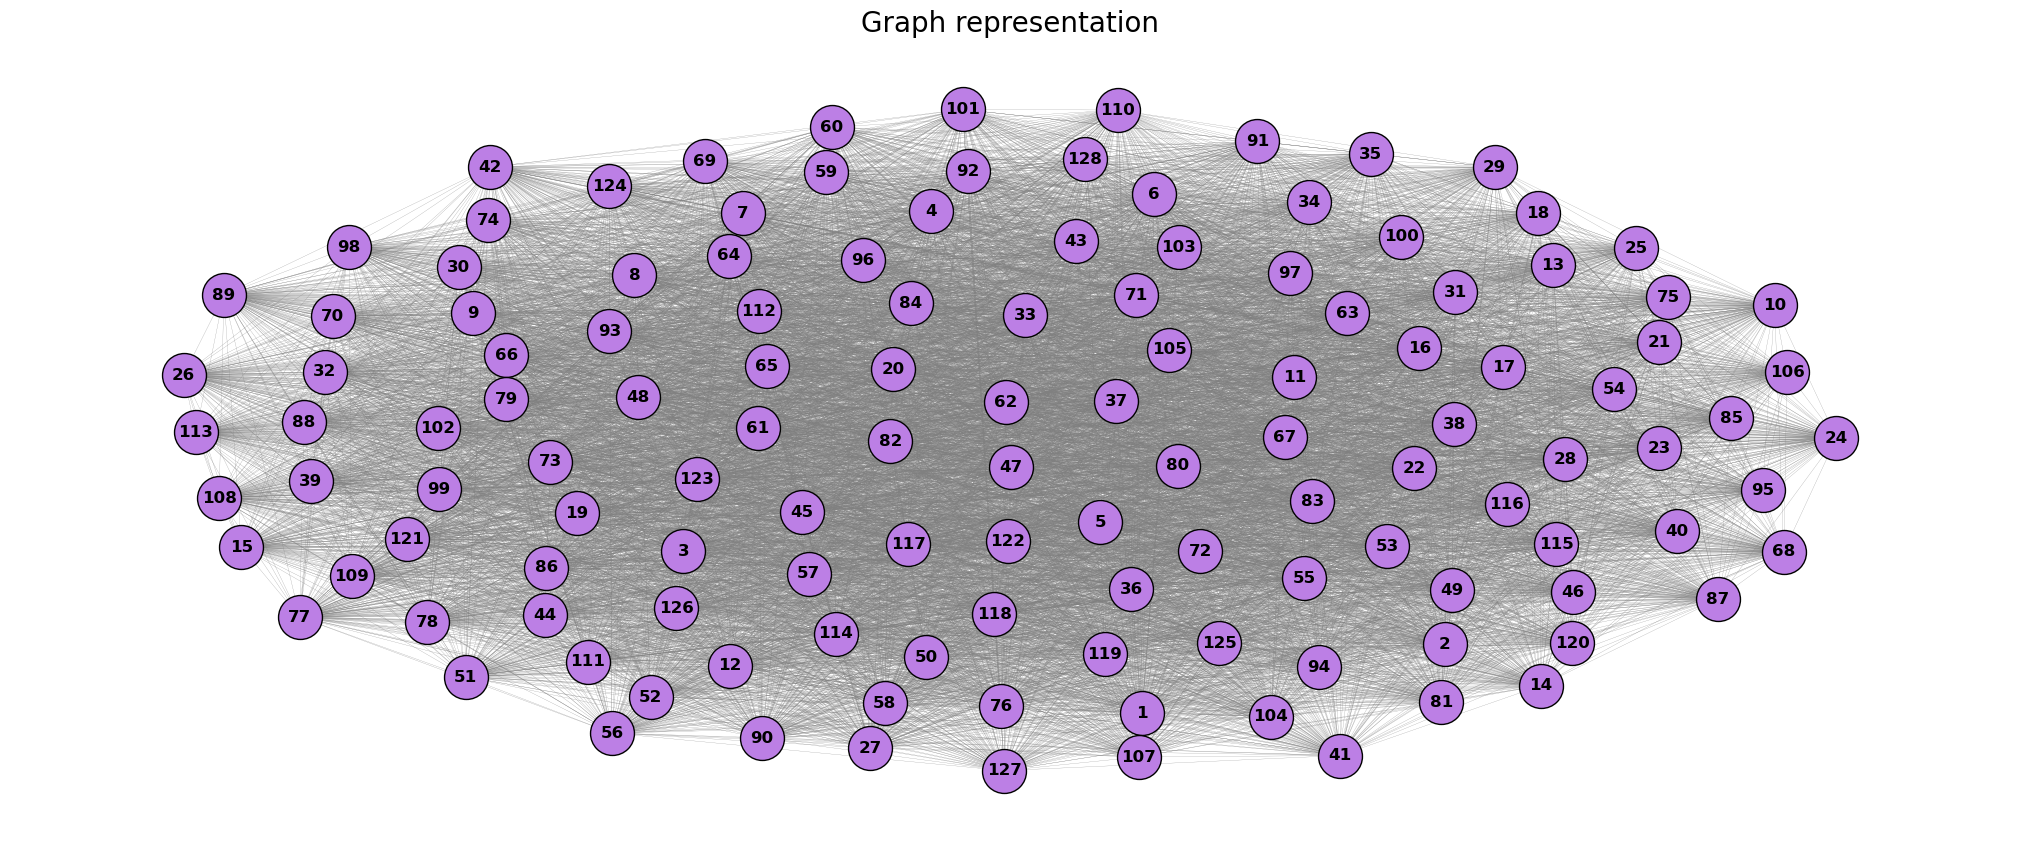

In [9]:
# Создание графа
G = nx.Graph()

# Добавление узлов в граф (начиная с 1)
for i in range(1, N + 1):
    G.add_node(i, label=f'Node {i}')

# Добавление рёбер в граф (используем теперь i и j с 1 по N)
for i in range(1, N + 1):
    for j in range(i + 1, N + 1):
        G.add_edge(i, j, weight=R[i-1, j-1])


# Отображение графа
pos = nx.spring_layout(G, k=0.9)
plt.figure(figsize=(20, 8))
nx.draw(G, pos, node_color='#bc7fe5', node_size=1_000, edge_color='grey',
        edgecolors='black', width=0.15, with_labels=True, font_weight='bold')

plt.title('Graph representation', size=20)
plt.show()

## Система

In [10]:
result = np.zeros(N)


@jit(nopython=True)
def system(phi, t, N, mu, omega, gamma, d, R):
    result = np.zeros(N)

    for j in range(N):
        summation = 0
        for k in range(N):
            # первое - есть ли связь, второе - сами с собой осц не связаны
            if (R[j, k] != 0) and (j != k):
                summation += R[j, k] * np.sin(phi[k] - phi[j] - gamma)
        if j + 1 <= N - 1:
            result[j] = mu / 2 * (omega[j] + d / R[j + 1, j] * summation)
        else:
            if R[0, j] != 0:   # будет 0 только когда связи произвольно заданы
                result[j] = mu / 2 * (omega[j] + d / R[0, j] * summation)
            else:
                result[j] = mu / 2 * omega[j]

    return result


phi0 = np.arange(0, 2*np.pi, 2*np.pi/N)

t_span = np.linspace(0, 1000, 1000)

solution = odeint(system, phi0, t_span, args=(N, mu, omega, gamma, d, R))

# приведение к [0, 2пи]
solution = np.fmod(solution, 2*np.pi)
# 0 и 2пи на окружности одна точка
solution[solution == 2*np.pi] -= 2*np.pi
# отрицательные привели к [0, 2пи]
solution[solution < 0] += 2*np.pi

#pprint(solution)

## Параметры порядка:

$R_1=\displaystyle \frac{1}{N}\Big|\sum^N_{j=1}e^{i\phi_j}\Big|$

$R_2=\displaystyle \frac{1}{N}\Big|\sum^N_{j=1}e^{2i\phi_j}\Big|$

Final values of R1 and R2:
R1: 0.9141112679095519
R2: 0.703216533420947


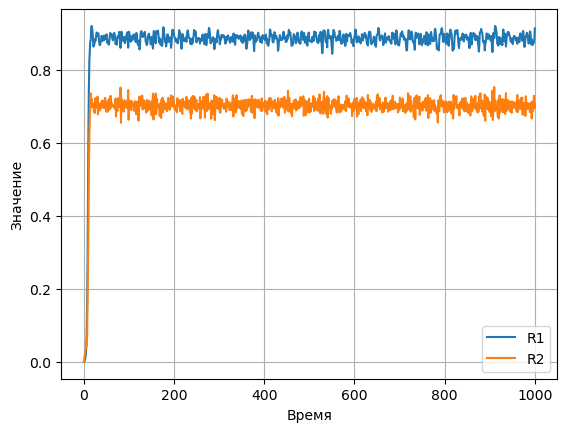

In [11]:
R1 = np.abs(np.mean(np.exp(1j * solution[:, :]), axis=1))
R2 = np.abs(np.mean(np.exp(2j * solution[:, :]), axis=1))

print("Final values of R1 and R2:")
print(f"R1: {R1[-1]}")
print(f"R2: {R2[-1]}")

with open("R1.txt", "a") as file:
    # Записать данные в файл
    file.write(f"{R1[-1]}\n")
with open("R2.txt", "a") as file:
    # Записать данные в файл
    file.write(f"{R2[-1]}\n")
    
# Построение графиков параметров порядка
plt.plot(t_span, R1, label='R1')
plt.plot(t_span, R2, label='R2')
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

## Пространственно-временная диаграмма

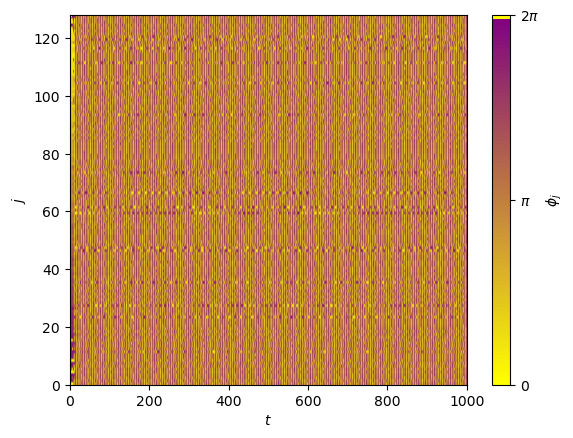

In [12]:
# Создание цветовой карты
colors = ['#FFFF00', '#800080']
n_bins = 100  # Количество оттенков

# 0 и 2*pi одним цветом
color_map_values = np.linspace([1, 1, 0], [128/255, 0, 128/255], n_bins)
color_map_values[0, :] = color_map_values[-1, :] = [1, 1, 0]

cmap_name = "custom_gradient"
custom_cmap = ListedColormap(color_map_values)

# Построение пространственно-временной диаграммы с градиентом цветовой карты
fig, ax = plt.subplots()
im = ax.imshow(solution.T, aspect='auto', cmap=custom_cmap, extent=[
               t_span[0], t_span[-1], 0, N], vmin=0, vmax=2*np.pi)
cb = plt.colorbar(im, ax=ax, label=fr'$\phi_j$', ticks=[0, np.pi, 2*np.pi])
cb.set_ticklabels(['$0$', '$\pi$', '$2\pi$'])

plt.xlabel(fr'$t$')
plt.ylabel(fr'$j$')
plt.show()

## Распределение осцилляторов

final time

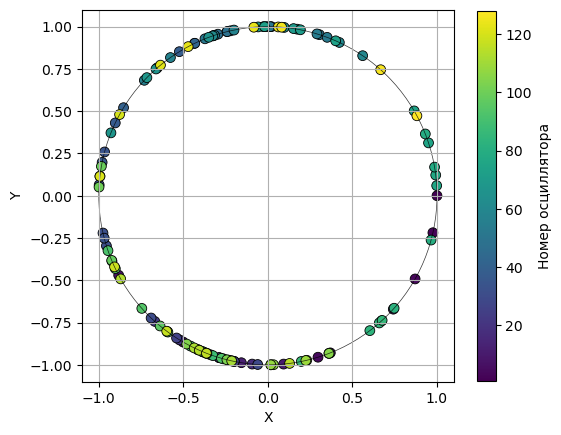

In [13]:
phi_diff = solution[-1, 1:] - solution[-1, 0]

theta = np.cumsum(np.concatenate(([0], phi_diff))) % (2 * np.pi)

x = np.cos(theta)
y = np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(x, y, c=range(1, N+1), cmap='viridis',
                s=50, edgecolor='black', linewidth=0.6)
ax.set_aspect('equal', 'box')

circle = plt.Circle((0, 0), 1, color='black',
                    fill=False, linewidth=0.5, alpha=0.8)
ax.add_patch(circle)
ax.grid()

cbar = plt.colorbar(sc, shrink=0.8)
cbar.set_label('Номер осциллятора')

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()